In [1]:
from DataPartition import DataPartition
from im_import import Import_GrayImg
import matplotlib
import matplotlib.pyplot as plt
import time
from datetime import datetime
import multiprocessing as mp
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import operator
from sklearn.preprocessing import LabelEncoder
import time
from mdl_nCh_adjuster import mdl_nCh_adjuster
import os
import sys
from RegularizeModel import RegularizeModel
from SaveModelDescript import SaveModelDescript
from ModelEditor import ModelEditor
from get_CompileParams import get_CompileParams
from callback_ConfMat import callback_ConfMat
import random

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

# Get fashion_mnist data

In [2]:
get_fashion_mnist = False

if get_fashion_mnist:
#     MasterPath = os.path.abspath("/gpfs0/home/jokhun/fashion_mnist/")
    MasterPath = os.path.abspath('//deptnas.nus.edu.sg/BIE/MBELab/jokhun/fashion_mnist/')   
    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_val = x_test ; y_val = y_test  
    
    idx=np.random.choice(range(0,len(x_train)), size=1000, replace=False)
    x_train=np.array([x_train[n] for n in idx])
    y_train=np.array([y_train[n] for n in idx])
    idx=np.random.choice(range(0,len(x_val)), size=750, replace=False)
    x_val=np.array([x_val[n] for n in idx])
    y_val=np.array([y_val[n] for n in idx])
    idx=np.random.choice(range(0,len(x_test)), size=500, replace=False)
    x_test=np.array([x_test[n] for n in idx])
    y_test=np.array([y_test[n] for n in idx])    
    
    X_Train = tf.expand_dims(x_train, axis=-1)
    X_Val = tf.expand_dims(x_val, axis=-1)
    X_Test = tf.expand_dims(x_test, axis=-1)
    print('X_Train shape:'+str(X_Train.shape) + '   X_Val shape:' + str(X_Val.shape) + '   X_Test shape:' + str(X_Test.shape))

    ResponseEncoder = LabelEncoder()
    ResponseEncoder.fit(list(y_train) + list(y_val) + list(y_test))
    class_names = ResponseEncoder.classes_
    NumOfClasses = len(class_names)
    print('Number of calsses in the data: '+str(NumOfClasses))
    print('Classes in the Data: ' + str(class_names))
    Y_Train = ResponseEncoder.transform(y_train)
    Y_Val = ResponseEncoder.transform(y_val)
    Y_Test = ResponseEncoder.transform(y_test)
    print ('1st element of Tr_Y, Val_Y and Ts_Y : ' + str(y_train[0]) + ', ' + str(y_val[0]) + ', ' + str(y_test[0]))
    print ('1st element of Y_Train, Y_Val and Y_Test : ' + str(Y_Train[0]) + ', ' + str(Y_Val[0]) + ', ' + str(Y_Test[0]))
    
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print('Actual Classes in the Data: ' + str(class_names))

# Input Data

#### Defining the input X and Y data

In [3]:
# MasterPath = os.path.abspath("/gpfs0/home/jokhun/")
MasterPath = os.path.abspath('//deptnas.nus.edu.sg/BIE/MBELab/jokhun/Pro 1/U2OS small mol screening')

Segmented_MasterFolder = 'Segmented_SmallMol'

Classes = sorted([Class for Class in os.listdir(os.path.join(MasterPath,Segmented_MasterFolder)) 
           if os.path.isdir(os.path.join(MasterPath,Segmented_MasterFolder,Class))])
print('Classes available :\n',Classes)

Classes available :
 ['0_DMSO_Complete', 'DMSO', 'caffeine', 'chlorphenamine', 'estradiol', 'paracetamol']


#### Use the following cell to select specific classes rather than all of them

In [4]:
Select_Classes = True # Set to False in order to select all available classes
selection = range(1,len(Classes))#[1,4] # List of classes to be selected. Only used if Select_Classes is True

if Select_Classes:
    Selected_Classes = list(operator.itemgetter(*selection)(Classes))
else:
    Selected_Classes = Classes

ClassPaths={}
for Class in Selected_Classes:
    ClassPaths[Class]=sorted(glob.glob(os.path.join(
        MasterPath,Segmented_MasterFolder,Class,f"*_{Class}.tif"
    )))

print('Classes selected :\n',Selected_Classes)
print('No. of Images available = ', np.sum([len(ClassPaths[Class]) for Class in ClassPaths]))
sorted_dict = {k: v for k, v in sorted(ClassPaths.items(), key=lambda item: len(item[1]))}
for Class in sorted_dict: print (Class,' : ',len(ClassPaths[Class]))

Classes selected :
 ['DMSO', 'caffeine', 'chlorphenamine', 'estradiol', 'paracetamol']
No. of Images available =  21996
estradiol  :  1982
caffeine  :  3104
paracetamol  :  3443
DMSO  :  6000
chlorphenamine  :  7467


#### Capping class size

In [5]:
# Restricting the number of images per class
cap_class_size = True

MaxClassSize = 64 #np.amin([len(items[1]) for items in ClassPaths.items()])
np.random.seed(None)

if cap_class_size:
    for Class in ClassPaths.keys():
        ClassPaths[Class]=sorted(np.random.choice(ClassPaths[Class], 
                                                  size = MaxClassSize, replace = True))
else:
    for Class in ClassPaths.keys():
        ClassPaths[Class]=sorted(ClassPaths[Class])

Ascd_ClassSizes = sorted([len(items[1]) for items in ClassPaths.items()])
print('Total No. of paths:', np.sum(Ascd_ClassSizes))
Max_Classes = [Class for Class in ClassPaths.keys() if len(ClassPaths[Class])==Ascd_ClassSizes[0]]
print('Min Class size:',Ascd_ClassSizes[0], Max_Classes)
Min_Classes = [Class for Class in ClassPaths.keys() if len(ClassPaths[Class])==Ascd_ClassSizes[-1]]
print('Max Class size:',Ascd_ClassSizes[-1], Min_Classes) 
print('\nClass sizes (ascending):',Ascd_ClassSizes) 

sorted_dict = {k: v for k, v in sorted(ClassPaths.items(), key=lambda item: len(item[1]))}
for Class in sorted_dict: print (Class,' : ',len(ClassPaths[Class]))

Total No. of paths: 320
Min Class size: 64 ['DMSO', 'caffeine', 'chlorphenamine', 'estradiol', 'paracetamol']
Max Class size: 64 ['DMSO', 'caffeine', 'chlorphenamine', 'estradiol', 'paracetamol']

Class sizes (ascending): [64, 64, 64, 64, 64]
DMSO  :  64
caffeine  :  64
chlorphenamine  :  64
estradiol  :  64
paracetamol  :  64


#### Partitioning data X and creating labels Y

In [6]:
# Y can be determined either from the filenames or the folders from which the images are loaded

get_labels_from = 'folders' # 'Filenames' or 'Folders'
RanSeed=None
Partition=[0.79,0.2,0.01]

PartitionedPaths = DataPartition(ClassPaths, Partition=Partition, RanSeed=RanSeed)

random.seed(RanSeed)
Tr_Paths=[]; Val_Paths=[]; Ts_Paths=[];
for key in PartitionedPaths.keys():
    Tr_Set,Val_Set,Ts_Set=PartitionedPaths[key]['Tr_Set'],PartitionedPaths[key]['Val_Set'],PartitionedPaths[key]['Ts_Set']
    Tr_Paths.extend(Tr_Set), Val_Paths.extend(Val_Set), Ts_Paths.extend(Ts_Set)
random.shuffle(Tr_Paths); random.shuffle(Val_Paths); random.shuffle(Ts_Paths);
Tr_Paths=np.array(Tr_Paths); Val_Paths=np.array(Val_Paths); Ts_Paths=np.array(Ts_Paths);

if get_labels_from.lower() == 'filenames':
    Tr_Y = [path[path.rindex('_') + 1 : path.index('.tif')] for path in Tr_Paths]
    Val_Y = [path[path.rindex('_') + 1 : path.index('.tif')] for path in Val_Paths]
    Ts_Y = [path[path.rindex('_') + 1 : path.index('.tif')] for path in Ts_Paths]

elif get_labels_from.lower() == 'folders':
    Tr_Y = [os.path.basename(os.path.dirname(path)) for path in Tr_Paths]
    Val_Y = [os.path.basename(os.path.dirname(path)) for path in Val_Paths]
    Ts_Y = [os.path.basename(os.path.dirname(path)) for path in Ts_Paths]
    
else: sys.exit("Invalid entry for 'get_labels_from'!")

print ('Total number of paths = ' + str(len(Tr_Paths)+len(Val_Paths)+len(Ts_Paths)))
print ('\nLength of Training Set = ' + str(len(Tr_Paths)))
values, counts = np.unique(Tr_Y, return_counts=True)
Dis_counts = [len(ClassPaths[Class])-(round(Ascd_ClassSizes[0]*Partition[2])+round(Ascd_ClassSizes[0]*Partition[1])) for Class in ClassPaths.keys()]
print ('Classes in Training Set : ' + str(values) + '\n ------- Frequencies : ' + str(counts) + '\n Distinct Frequencies : ' + str(Dis_counts))
print ('\nLength of Validation Set = ' + str(len(Val_Paths)))
values, counts = np.unique(Val_Y, return_counts=True)
Dis_counts = round(Ascd_ClassSizes[0]*Partition[1])
print ('Classes in Training Set : ' + str(values) + '\n ------- Frequencies : ' + str(counts) + '\n Distinct Frequencies : ' + str(Dis_counts))
print ('\nLength of Test Set = ' + str(len(Ts_Paths)))
values, counts = np.unique(Ts_Y, return_counts=True)
Dis_counts = round(Ascd_ClassSizes[0]*Partition[2])
print ('Classes in Training Set : ' + str(values) + '\n ------- Frequencies : ' + str(counts) + '\n Distinct Frequencies : ' + str(Dis_counts))

print (f'\n1st element of Training Set : {Tr_Y[0]}\n' + str(Tr_Paths[0]))
print (f'1st element of Validation Set : {Val_Y[0]}\n' + str(Val_Paths[0]))
print (f'1st element of Test Set : {Ts_Y[0]}\n' + str(Ts_Paths[0]))


Total number of paths = 320

Length of Training Set = 250
Classes in Training Set : ['DMSO' 'caffeine' 'chlorphenamine' 'estradiol' 'paracetamol']
 ------- Frequencies : [50 50 50 50 50]
 Distinct Frequencies : [50, 50, 50, 50, 50]

Length of Validation Set = 65
Classes in Training Set : ['DMSO' 'caffeine' 'chlorphenamine' 'estradiol' 'paracetamol']
 ------- Frequencies : [13 13 13 13 13]
 Distinct Frequencies : 13

Length of Test Set = 5
Classes in Training Set : ['DMSO' 'caffeine' 'chlorphenamine' 'estradiol' 'paracetamol']
 ------- Frequencies : [1 1 1 1 1]
 Distinct Frequencies : 1

1st element of Training Set : paracetamol
\\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol\paracetamol\24311_a12_s6_30_paracetamol.tif
1st element of Validation Set : chlorphenamine
\\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\Segmented_SmallMol\chlorphenamine\25943_b11_s1_21_chlorphenamine.tif
1st element of Test Set : caffeine
\\deptnas.

#### Import images: Tr_X, Val_X and Ts_X

Time elapsed during import = 2.469188496000001 s
Length of Training Set = 250
Length of Validation Set = 65
Length of Test Set = 5


(Text(0.5, 1.0, 'Test[0]'), <matplotlib.image.AxesImage at 0x20b0b701c08>)

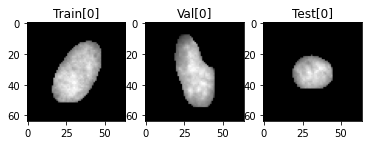

In [7]:
ImgScaleFactor = 1
DesiredImgSize = 64

start=time.perf_counter()
with mp.Pool() as pool:
    Tr_X = pool.starmap(Import_GrayImg, [(path,ImgScaleFactor,DesiredImgSize) for path in Tr_Paths])
    Val_X = pool.starmap(Import_GrayImg, [(path,ImgScaleFactor,DesiredImgSize) for path in Val_Paths])
    Ts_X = pool.starmap(Import_GrayImg, [(path,ImgScaleFactor,DesiredImgSize) for path in Ts_Paths])
print('Time elapsed during import = '+ str(time.perf_counter() - start) + ' s')

print ('Length of Training Set = '+str(len(Tr_X)))
print ('Length of Validation Set = '+str(len(Val_X)))
print ('Length of Test Set = '+str(len(Ts_X)))

plt.subplot(1,3,1).set_title('Train[0]'), plt.imshow(Tr_X[0], cmap='gray', norm=matplotlib.colors.Normalize())
plt.subplot(1,3,2).set_title('Val[0]'), plt.imshow(Val_X[0], cmap='gray', norm=matplotlib.colors.Normalize())
plt.subplot(1,3,3).set_title('Test[0]'), plt.imshow(Ts_X[0], cmap='gray', norm=matplotlib.colors.Normalize())

In [8]:
# Getting rid of invalid images (if th enucleus was too large to fit within 'DesiredImgSize')
Invalid_Tr = [i for i,val in enumerate(Tr_X) if type(val)==type(None)]
for idx in sorted(Invalid_Tr, reverse=True):
    del Tr_X[idx]
    del Tr_Y[idx]

Invalid_Val = [i for i,val in enumerate(Val_X) if type(val)==type(None)]
for idx in sorted(Invalid_Val, reverse=True):
    del Val_X[idx]
    del Val_Y[idx]

Invalid_Ts = [i for i,val in enumerate(Ts_X) if type(val)==type(None)]
for idx in sorted(Invalid_Ts, reverse=True):
    del Ts_X[idx]
    del Ts_Y[idx]

print ('Total number of invalid files = '+str(len(Invalid_Tr)+len(Invalid_Val)+len(Invalid_Ts)))
values, counts = np.unique(Tr_Y, return_counts=True)
print ('Classes in Training Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
values, counts = np.unique(Val_Y, return_counts=True)
print ('Classes in Validation Set : ' + str(values) + ' --- Frequencies : ' + str(counts))
values, counts = np.unique(Ts_Y, return_counts=True)
print ('Classes in Test Set : ' + str(values) + ' --- Frequencies : ' + str(counts))

print('\nInvalid Traininig files = '+str(len(Invalid_Tr))+'\n'+str(operator.itemgetter(Invalid_Tr)(Tr_Paths)))
print('\nInvalid Val files = '+str(len(Invalid_Val))+'\n'+str(operator.itemgetter(Invalid_Val)(Val_Paths)))
print('\nInvalid Test files = '+str(len(Invalid_Ts))+'\n'+str(operator.itemgetter(Invalid_Ts)(Ts_Paths)))
Tr_Paths = np.delete(Tr_Paths,Invalid_Tr)
Val_Paths = np.delete(Val_Paths,Invalid_Val)
Ts_Paths = np.delete(Ts_Paths,Invalid_Ts)

Total number of invalid files = 0
Classes in Training Set : ['DMSO' 'caffeine' 'chlorphenamine' 'estradiol' 'paracetamol'] --- Frequencies : [50 50 50 50 50]
Classes in Validation Set : ['DMSO' 'caffeine' 'chlorphenamine' 'estradiol' 'paracetamol'] --- Frequencies : [13 13 13 13 13]
Classes in Test Set : ['DMSO' 'caffeine' 'chlorphenamine' 'estradiol' 'paracetamol'] --- Frequencies : [1 1 1 1 1]

Invalid Traininig files = 0
[]

Invalid Val files = 0
[]

Invalid Test files = 0
[]


#### Restructuring the image dataset and encoding the labels

In [9]:
X_Train = tf.expand_dims(Tr_X, axis=-1)
X_Val = tf.expand_dims(Val_X, axis=-1)
X_Test = tf.expand_dims(Ts_X, axis=-1)
print('X_Train shape:'+str(X_Train.shape) + '   X_Val shape:' + str(X_Val.shape) + '   X_Test shape:' + str(X_Test.shape))

ResponseEncoder = LabelEncoder()
ResponseEncoder.fit(list(Tr_Y) + list(Val_Y) + list(Ts_Y))
class_names = ResponseEncoder.classes_
NumOfClasses = len(class_names)
print('Number of calsses in the data: '+str(NumOfClasses))
print('Classes in the Data: ' + str(class_names))
Y_Train = ResponseEncoder.transform(Tr_Y)
Y_Val = ResponseEncoder.transform(Val_Y)
Y_Test = ResponseEncoder.transform(Ts_Y)
print ('1st element of Tr_Y, Val_Y and Ts_Y : ' + str(Tr_Y[0]) + ', ' + str(Val_Y[0]) + ', ' + str(Ts_Y[0]))
print ('1st element of Y_Train, Y_Val and Y_Test : ' + str(Y_Train[0]) + ', ' + str(Y_Val[0]) + ', ' + str(Y_Test[0]))

X_Train shape:(250, 64, 64, 1)   X_Val shape:(65, 64, 64, 1)   X_Test shape:(5, 64, 64, 1)
Number of calsses in the data: 5
Classes in the Data: ['DMSO' 'caffeine' 'chlorphenamine' 'estradiol' 'paracetamol']
1st element of Tr_Y, Val_Y and Ts_Y : paracetamol, chlorphenamine, caffeine
1st element of Y_Train, Y_Val and Y_Test : 4, 2, 1


# Getting the models ready

### Instantiating keras models 

In [10]:
CreateModel = True

models = {}
if CreateModel:
    models['try_Xception'] = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(299, 299, 3), pooling='avg')
#     models['try_InceptionV3'] = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(299, 299, 3), pooling='avg')
#     models['try_InceptionResNetV2'] = tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(299, 299, 3), pooling='avg')
#     models['try_ResNet50V2'] = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='avg')
#     models['try_DenseNet201'] = tf.keras.applications.DenseNet201(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='avg')
#     models['try_NASNetLarge'] = tf.keras.applications.NASNetLarge(include_top=False, weights="imagenet", input_shape=(331, 331, 3), pooling='avg')
          
    ModelKeys=list(models.keys())
    ModelsCreated = len(ModelKeys)
    print (str(ModelsCreated),' model/s created!')
else:
    print ('No model created. Load one from disk below!')    

1  model/s created!


### Saving model description

In [11]:
SaveModelDescription = False

if SaveModelDescription:
    for ModelKey in ModelKeys:
        model = models[ModelKey]
        Model_Path = os.path.join(MasterPath,str(ModelKey))        
        SaveModelDescript(model, save_dir=Model_Path, 
                          save_filename=str(ModelKey))        
    print ('Model descriptions saved!')

### Editing the model

In [12]:
Edit_Model = False
SaveEditedModelDescription = True
ModelKey = ModelKeys[0]

if Edit_Model:
    model = models[ModelKey]
    New_Layers={'drop1':tf.keras.layers.Dropout(rate=0.1, name='drop1'),
                'drop2':tf.keras.layers.Dropout(rate=0.2, name='drop2'),
                'drop3':tf.keras.layers.Dropout(rate=0.3, name='drop3'),
                'drop4':tf.keras.layers.Dropout(rate=0.4, name='drop4'),
                'drop5':tf.keras.layers.Dropout(rate=0.5, name='drop5'),
               }

    IncomingLinks_2Axe=[-18, -12, -14, -8, -5, -1]   

    IncomingLinks_2Forge=[(New_Layers['drop1'], model.layers[-19]),
                          (model.layers[-18], New_Layers['drop1']),
                          (model.layers[-12], New_Layers['drop1']),
                          (New_Layers['drop2'], model.layers[-15]),
                          (model.layers[-14], New_Layers['drop2']),
                          (New_Layers['drop3'], model.layers[-9]),
                          (model.layers[-8], New_Layers['drop3']),
                          (New_Layers['drop4'], model.layers[-6]),
                          (model.layers[-5], New_Layers['drop4']),
                          (New_Layers['drop5'], model.layers[-2]),
                          (model.layers[-1], New_Layers['drop5']),
                         ]

    model_inputs=None
    model_outputs=None

    model = ModelEditor(model, New_Layers=New_Layers, IncomingLinks_2Axe=IncomingLinks_2Axe, 
                                IncomingLinks_2Forge=IncomingLinks_2Forge,
                                model_inputs=model_inputs, model_outputs=model_outputs)
    models[ModelKey] = model 
    
    # Save edited model description
    if SaveEditedModelDescription:
        Model_Path = os.path.join(MasterPath,str(ModelKey))        
        SaveModelDescript(model, save_dir=Model_Path, 
                          save_filename=str(ModelKey+'_edited'))        
        print ('Model descriptions saved!')

### Adding Top and Bottom layers to keras models instantiated above

In [13]:
AddTopAndBottomLayers = True

if AddTopAndBottomLayers:
    ModelKeys=list(models.keys())
    for ModelKey in ModelKeys:
        mdl = models[ModelKey]
        im_preprocess = mdl_nCh_adjuster(Input_ImgSize=X_Train.shape[1:4], Output_ImgSize=mdl.input_shape[1:4])
        predictions = tf.keras.layers.Dense(units=NumOfClasses, activation=None, name="predictions")
        
        In = tf.keras.Input(shape=(X_Train.shape[1:4]), name="Input")
        Out = predictions(mdl(im_preprocess(In)))
        models[ModelKey] = tf.keras.Model(inputs=In, outputs=Out, name=ModelKey)
    print ('Bottom and Top layers added!')    

Bottom and Top layers added!


### Saving model description

In [14]:
SaveModelDescription = True

if SaveModelDescription:
    ModelKeys=list(models.keys())
    for ModelKey in ModelKeys:
        model = models[ModelKey]
        Model_Path = os.path.join(MasterPath,str(ModelKey))        
        SaveModelDescript(model, save_dir=Model_Path, 
                          save_filename=str(ModelKey))        
    print ('Model descriptions saved!')

Model descriptions saved!


### Compiling the models

In [15]:
CompileModels = True

if CompileModels:
    ModelKeys = list(models.keys())
    for ModelKey in ModelKeys:
        model = models[ModelKey]
        optimizer,loss,metrics,loss_weights,weighted_metrics,run_eagerly = get_CompileParams (model).values()
        if optimizer!=None:
            model.compile(optimizer = optimizer,
                          loss = loss,
                          metrics = metrics,
                          loss_weights = loss_weights,
                          weighted_metrics = weighted_metrics,
                          run_eagerly = run_eagerly)
        else:
            model.compile(optimizer='adam', 
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                          metrics=['accuracy'])
    print ('Models compiled!')

Models compiled!


### Loading models from disk

In [16]:
LoadModelFromDisk = False

if LoadModelFromDisk:
    models['mdl_name'] = tf.keras.models.load_model('mdl_path')
    
    ModelsLoaded = len(models.keys()) - ModelsCreated
    print (str(ModelsLoaded),' models loaded from disk!')
else:
    print ('No model loaded from disk!')

No model loaded from disk!


### Adding Regularization to all regularizable layers

In [17]:
RegularizeTheModel = False
if RegularizeTheModel:
    regularizer = tf.keras.regularizers.l1_l2(l1=0, l2=0.001)
    for ModelKey in ModelKeys:
        models[ModelKey]=RegularizeModel(models[ModelKey], regularizer, keep_weights=True)
    

### Summary of models

In [18]:
ModelKeys=list(models.keys())

print ('Total number of models = ',str(len(models.keys())))
print ('Initial Train Loss and Accuracy')
TrainEval=[]
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Train,Y_Train, verbose=0)
    TrainEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(TrainEval)) 

print ('\nInitial Val Loss and Accuracy')
ValEval=[]
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Val,Y_Val, verbose=0)
    ValEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(ValEval)) 

print ('\nInitial Test Loss and Accuracy')
TestEval=[]
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Test,Y_Test, verbose=0)
    TestEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(TestEval)) 


Total number of models =  1
Initial Train Loss and Accuracy
try_Xception : [1.628331735610962, 0.184]

Initial Val Loss and Accuracy
try_Xception : [1.6453870773315429, 0.15384616]

Initial Test Loss and Accuracy
try_Xception : [1.6482703685760498, 0.2]


## Setting up the ImageDataGenerator

In [19]:
UseImageDataGenerator = False

def ImgGrayscale (img):
    bw = img>0
    img = np.subtract(img, np.amin(img))
    img = np.divide(img, np.amax(img))
    img = img*bw   
    return img

if UseImageDataGenerator:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=180,
        width_shift_range=0.0,
        height_shift_range=0.0,
        brightness_range=None,
        shear_range=0.0,
        zoom_range=0.0,
        channel_shift_range=0.0,
        fill_mode="constant",
        cval=0,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None,
        preprocessing_function=ImgGrayscale,
        data_format=None,
        validation_split=0.0,
        dtype=None,
    )
else:
    datagen = ImageDataGenerator(preprocessing_function=ImgGrayscale)

## Training config

In [20]:
def train_model (model, X_Train=None, Y_Train=None, X_Val=None, Y_Val=None, batch_size=64, initial_epoch=0, final_epoch=5, Model_Path=None, class_names=None, shuffle=True, DatagenShuffleSeed=None):
    if Model_Path==None or Model_Path==[]:
        Model_Path=model.name     
        
        
    sess_DateTime = str(datetime.now().strftime("%Y%m%d-%H%M%S"))
    MdlChkpt_Path = os.path.join(Model_Path,"MdlChkpt",(sess_DateTime+"_e{epoch:03d}_Acc{accuracy:.2f}_ValAcc{val_accuracy:.2f}.ckpt"))
    MdlChkpt_cb = tf.keras.callbacks.ModelCheckpoint(
        MdlChkpt_Path, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, 
        mode='auto', save_freq="epoch"
    )
    TensorBoard_Path = os.path.join(Model_Path,"logs",(model.name+'_'+sess_DateTime))
    TensorBoard_cb = tf.keras.callbacks.TensorBoard(
        log_dir = TensorBoard_Path, histogram_freq=0, write_graph=False, write_images=False, update_freq="epoch", 
        profile_batch=0, embeddings_freq=0, embeddings_metadata=None
    )
    
    ConfMat_Path = os.path.join(Model_Path,"logs",(model.name+'_'+sess_DateTime))
    log_confusion_matrix=callback_ConfMat(model=model, X=X_Val, Y=Y_Val, class_names=class_names, logdir=ConfMat_Path)
    # Define the per-epoch callback.
    ConfMat_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
    
    
    model.fit(
        datagen.flow(x=X_Train, y=Y_Train, batch_size=batch_size, 
                     shuffle=shuffle, sample_weight=None,seed=DatagenShuffleSeed,
                     save_to_dir=None,save_prefix="",save_format="png",subset=None),
        initial_epoch=initial_epoch, epochs=final_epoch, steps_per_epoch=len(X_Train)/batch_size, 
        verbose=1, callbacks=[MdlChkpt_cb, TensorBoard_cb, ConfMat_cb], 
        validation_data=(X_Val,Y_Val), shuffle=shuffle, use_multiprocessing=False
    )        
    
    return

## Training top and bottom layers

#### Setting the main model as non-trainable

In [21]:
TrainTopAndBottomOnly = True
MainModel_layer = -2

if TrainTopAndBottomOnly:
    ModelKeys=list(models.keys())
    for ModelKey in ModelKeys:
        model=models[ModelKey]
        model.layers[MainModel_layer].trainable = False
        print (model.layers[MainModel_layer].name,' has been set as non-trainable')

xception  has been set as non-trainable


#### Compiling the models

In [22]:
if TrainTopAndBottomOnly:
    ModelKeys = list(models.keys())
    for ModelKey in ModelKeys:
        model = models[ModelKey]
        optimizer,loss,metrics,loss_weights,weighted_metrics,run_eagerly = get_CompileParams (model).values()
        if optimizer!=None:
            model.compile(optimizer = optimizer,
                          loss = loss,
                          metrics = metrics,
                          loss_weights = loss_weights,
                          weighted_metrics = weighted_metrics,
                          run_eagerly = run_eagerly)
        else:
            model.compile(optimizer='adam', 
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                          metrics=['accuracy'])
    print ('Models compiled!')

Models compiled!


#### Training the top and bottom layers of the models

In [23]:
if TrainTopAndBottomOnly:
    Start=time.perf_counter()
    ModelKeys=list(models.keys())
    for ModelKey in ModelKeys:
        ModelStart=time.perf_counter()
        print('\nTraining '+str(ModelKey)+'...')
        Model_Path = os.path.join(MasterPath,str(ModelKey))
        model = models[ModelKey]
        
        train_model (model, X_Train=X_Train, Y_Train=Y_Train, X_Val=X_Val, Y_Val=Y_Val, 
                     batch_size=32, initial_epoch=0, final_epoch=3,
                     Model_Path=Model_Path, class_names=class_names, shuffle=True, DatagenShuffleSeed=None)
        
        print('\n'+str(ModelKey)+' trained! Training time = '+ str((time.perf_counter()-ModelStart)/60) + ' min!')
    print('\nTotal training time = '+ str((time.perf_counter()-Start)/(60*60)) + ' hr!')        
        


Training try_Xception...
  ...
    to  
  ['...']
Train for 7.8125 steps, validate on 65 samples
Epoch 1/3
8/7 [==============================] - 22s 3s/step - loss: 1.6427 - accuracy: 0.1720 - val_loss: 1.6440 - val_accuracy: 0.1846
Epoch 2/3
8/7 [==============================] - 6s 760ms/step - loss: 1.5758 - accuracy: 0.2440 - val_loss: 1.6471 - val_accuracy: 0.1692
Epoch 3/3
8/7 [==============================] - 6s 769ms/step - loss: 1.5198 - accuracy: 0.3920 - val_loss: 1.6511 - val_accuracy: 0.1846

try_Xception trained! Training time = 0.5783708259166666 min!

Total training time = 0.00963969628777778 hr!


#### Summary of Models

In [24]:
print ('Total number of models = ',str(len(models.keys())))
print ('Train Loss and Accuracy')
TrainEval=[]
ModelKeys=list(models.keys())
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Train,Y_Train, verbose=0)
    TrainEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(TrainEval)) 

print ('\nVal Loss and Accuracy')
ValEval=[]
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Val,Y_Val, verbose=0)
    ValEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(ValEval)) 

print ('\nTest Loss and Accuracy')
TestEval=[]
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Test,Y_Test, verbose=0)
    TestEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(TestEval)) 

Total number of models =  1
Train Loss and Accuracy
try_Xception : [1.6297143392562867, 0.22]

Val Loss and Accuracy
try_Xception : [1.651113821909978, 0.18461539]

Test Loss and Accuracy
try_Xception : [1.6646039485931396, 0.2]


## Training full models

#### Setting the main model as trainable

In [25]:
TrainFullModel = True

if TrainFullModel:
    ModelKeys=list(models.keys())
    for ModelKey in ModelKeys:
        model=models[ModelKey]
        model.layers[MainModel_layer].trainable = True
        print (model.layers[MainModel_layer].name,' has been set as trainable')

xception  has been set as trainable


#### Compiling the models

In [26]:
if TrainFullModel:
    ModelKeys = list(models.keys())
    for ModelKey in ModelKeys:
        model = models[ModelKey]
        optimizer,loss,metrics,loss_weights,weighted_metrics,run_eagerly = get_CompileParams (model).values()
        if optimizer!=None:
            model.compile(optimizer = optimizer,
                          loss = loss,
                          metrics = metrics,
                          loss_weights = loss_weights,
                          weighted_metrics = weighted_metrics,
                          run_eagerly = run_eagerly)
        else:
            model.compile(optimizer='adam', 
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                          metrics=['accuracy'])
    print ('Models compiled!')

Models compiled!


#### Training full models

In [27]:
if TrainFullModel:
    Start=time.perf_counter()
    ModelKeys=list(models.keys())
    for ModelKey in ModelKeys:
        ModelStart=time.perf_counter()
        print('\nTraining '+str(ModelKey)+'...')
        Model_Path = os.path.join(MasterPath,str(ModelKey))
        model = models[ModelKey]
        
        train_model (model, X_Train=X_Train, Y_Train=Y_Train, X_Val=X_Val, Y_Val=Y_Val, 
                     batch_size=32, initial_epoch=3, final_epoch=5,
                     Model_Path=Model_Path, class_names=class_names, shuffle=True, DatagenShuffleSeed=None)
        
        print('\n'+str(ModelKey)+' trained! Training time = '+ str((time.perf_counter()-ModelStart)/60) + ' min!')
    print('\nTotal training time = '+ str((time.perf_counter()-Start)/(60*60)) + ' hr!')  


Training try_Xception...
  ...
    to  
  ['...']
Train for 7.8125 steps, validate on 65 samples
Epoch 4/5
8/7 [==============================] - 45s 6s/step - loss: 1.5922 - accuracy: 0.2640 - val_loss: 1.6200 - val_accuracy: 0.2000
Epoch 5/5
8/7 [==============================] - 29s 4s/step - loss: 1.5858 - accuracy: 0.3280 - val_loss: 1.6202 - val_accuracy: 0.2308

try_Xception trained! Training time = 1.23171163935 min!

Total training time = 0.020528580910000007 hr!


#### Summary of Models

In [28]:
print ('Total number of models = ',str(len(models.keys())))
print ('Train Loss and Accuracy')
TrainEval=[]
ModelKeys=list(models.keys())
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Train,Y_Train, verbose=0)
    TrainEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(TrainEval)) 

print ('\nVal Loss and Accuracy')
ValEval=[]
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Val,Y_Val, verbose=0)
    ValEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(ValEval)) 

print ('\nTest Loss and Accuracy')
TestEval=[]
for ModelKey in ModelKeys:
    Eval=models[ModelKey].evaluate(X_Test,Y_Test, verbose=0)
    TestEval.append(str(ModelKey)+' : '+str(Eval))
print ('\n'.join(TestEval)) 

Total number of models =  1
Train Loss and Accuracy
try_Xception : [1.5790146799087525, 0.256]

Val Loss and Accuracy
try_Xception : [1.6202160064990705, 0.23076923]

Test Loss and Accuracy
try_Xception : [1.5560027360916138, 0.4]


# Saving the latest version of each model

In [29]:
SaveLatestVersions = True
if SaveLatestVersions:
    sess = datetime.now().strftime("%Y%m%d-%H%M%S")
    for ModelKey in ModelKeys:
        print('\nSaving '+str(ModelKey))
        Save_Path = os.path.join(MasterPath,str(ModelKey),("LastModel_"+sess))
        models[ModelKey].save(
            Save_Path, overwrite=False, include_optimizer=True, save_format=None,
            signatures=None, options=None
        )
    print('\nThe latest version of each model has been saved!')


Saving try_Xception
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: \\deptnas.nus.edu.sg\BIE\MBELab\jokhun\Pro 1\U2OS small mol screening\try_Xception\LastModel_20200806-165909\assets

The latest version of each model has been saved!
